In [1]:
import preprocessing.read as r
import preprocessing.st_ops as ops
import visualization.builders as vis

import torch

from torch_geometric.data import Data
from torch_geometric.data import Batch

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from IPython.display import display

import numpy as np

from pythreejs import *

from math import pi

# Lendo dataset

In [2]:
loader = r.TaekwondoLoader('../dataset')
athletes, labels, label_idx = loader.load();
print(labels)
print(athletes[0])
print(label_idx)

l = { idx: key for (idx, key) in enumerate(labels)}

{'Right Punch', 'Left Punch', 'Right Kick To The Head', 'Back Kick', 'Left Kick', 'Right Kick', 'Left Kick To The Head'}
Athlete  8
	Left Punch -> 18 frames
	Right Kick To The Head -> 27 frames
	Right Punch -> 24 frames
	Left Kick -> 26 frames
	Right Kick -> 39 frames
	Back Kick -> 44 frames
	Left Kick To The Head -> 41 frames

{'Right Punch': 0, 'Left Punch': 1, 'Right Kick To The Head': 2, 'Back Kick': 3, 'Left Kick': 4, 'Right Kick': 5, 'Left Kick To The Head': 6}


In [3]:
frame = athletes[0].get('Back Kick')[0]
print(frame)

[[  31.396835  379.187256 2674.777832]
 [-120.293671  370.172241 2366.48291 ]
 [-127.841354  572.247986 2565.340088]
 [  37.214878  167.52269  2486.507324]
 [  73.489693  -42.331818 2360.136963]
 [ 164.266663  -36.93692  2544.631592]
 [   0.          0.          0.      ]
 [  31.374451   84.170746 2674.909424]
 [ -71.856354   75.832153 2220.5625  ]
 [  27.544174 -209.728271 2649.543213]
 [-204.983688 -189.619232 2283.550049]
 [   0.          0.          0.      ]
 [   0.          0.          0.      ]
 [  44.721283 -440.499054 2584.800537]
 [ 135.381165 -489.137695 2363.15332 ]
 [ 274.684814 -755.539368 2478.226318]
 [ 193.036957 -912.540833 2427.563965]
 [   0.          0.          0.      ]
 [   0.          0.          0.      ]
 [ -44.448421  374.679749 2520.630371]]


In [4]:
for athlete in athletes:

    min_y = float("inf")
    max_y = -float("inf")
    min_x = float("inf")
    max_x = -float("inf")
    min_z = float("inf")
    max_z = -float("inf")

    for label in labels:
        activity = athlete.get(label)
        min_x = min(min_x, activity[:,:,0].min())
        max_x = max(max_x, activity[:,:,0].max())
        min_y = min(min_y, activity[:,:,1].min())
        max_y = max(max_y, activity[:,:,1].max())
        min_z = min(min_z, activity[:,:,2].min())
        max_z = max(max_z, activity[:,:,2].max())

    scale = (max_y - min_y)/2  # A mesma escala será usada nas 3 dimensões para preservar proporção
    move_x = -(min_x + max_x)/2
    move_y = -(min_y + max_y)/2
    move_z = -(min_z + max_z)/2

    for label in labels:
        activity = athlete.get(label)
        activity[:,:,0] = (activity[:,:,0] + move_x)/scale
        activity[:,:,1] = (activity[:,:,1] + move_y)/scale
        activity[:,:,2] = (activity[:,:,2] + move_z)/scale

In [6]:
athletes[0].get(label)

array([[[-0.09324845,  0.78366053,  0.94949473],
        [-0.15028393,  0.70058169,  1.28049879],
        [-0.14186299,  0.96491675,  1.17798114],
        ...,
        [-0.16838569,  0.31948993, -1.57067991],
        [-0.16838569,  0.31948993, -1.57067991],
        [-0.12176619,  0.74212109,  1.11499676]],

       [[-0.19449187,  0.78339139,  0.9245332 ],
        [-0.07844772,  0.72975749,  1.24460678],
        [-0.15699785,  0.98039589,  1.138679  ],
        ...,
        [-0.16838569,  0.31948993, -1.57067991],
        [-0.16838569,  0.31948993, -1.57067991],
        [-0.1364698 ,  0.75657444,  1.08456999]],

       [[-0.22728895,  0.77844252,  0.92675489],
        [-0.0690875 ,  0.73506471,  1.2309514 ],
        [-0.16618662,  0.98190674,  1.12567961],
        ...,
        [-0.16838569,  0.31948993, -1.57067991],
        [-0.16838569,  0.31948993, -1.57067991],
        [-0.14818822,  0.75675361,  1.07885315]],

       ...,

       [[-0.22213513,  0.77459746,  0.9660557 ],
        [-0

# Matriz de adjacências do esqueleto

In [7]:
adj_list = {
    0: [3, 7, 19, 6],
    1: [3, 8, 19, 6],
    2: [19, 6],
    3: [0, 1, 4, 5, 19, 6],
    4: [3, 5, 14, 6],
    5: [3, 4, 13, 6],
    6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 14, 15, 16, 19],
    7: [0, 9, 6],
    8: [1, 10, 6],
    9: [7, 6],
    10: [8, 6],
    13: [5, 15, 6],
    14: [4, 16, 6],
    15: [13, 6],
    16: [14, 6],
    19: [0, 1, 2, 3, 6]
}

In [8]:
node_html_colors = { 
    0: '#FFFF00',
    1: '#02FF00',
    2: '#666666',
    3: '#FF00FF',
    4: '#02FF00',
    5: '#FFFF00',
    6: '#666666',
    7: '#FF9802',
    8: '#02FFFF',
    9: '#FF0000',
    10: '#0600FF',
    11: '#000000',
    12: '#000000',
    13: '#FF9802',
    14: '#02FFFF',
    15: '#FF0000',
    16: '#0600FF',
    17: '#000000',
    18: '#000000',
    19: '#FF00FF'
}

In [9]:

edges = ops.adjlist_to_coo(adj_list)

edge_index = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(frame, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(edge_index=[2, 64], x=[20, 3])


In [10]:

def animate_function(i, action, edges, node_html_colors):
    colors = [[1,0,0],[0,0.5,0],[0,0.8,0.8],[0.8,0.8,0],[0,0,1]]
    ax.clear()
    ax.axis([-1.5, 1.5, -1.5 ,1.5])
    frame = action[i]
    axis_x = frame[:,0]
    axis_y = frame[:,1]
    for edge_index in range(edges.shape[1]):        
        s_x = axis_x[edges[0,edge_index]]
        s_y = axis_y[edges[0,edge_index]]
        t_x = axis_x[edges[1,edge_index]]
        t_y = axis_y[edges[1,edge_index]]
        line = plt.Line2D((s_x,t_x), (s_y,t_y))
        ax.add_artist(line)
    for node_index in range(len(axis_x)):
        node_color = matplotlib.colors.to_rgb(node_html_colors[node_index])
        circle = plt.Circle((axis_x[node_index], axis_y[node_index]), .05, color=node_color)
        ax.add_artist(circle)
        ax.annotate(node_index, xy=(axis_x[node_index], axis_y[node_index]))

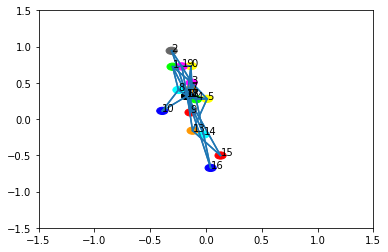

In [20]:
fig = plt.figure()
ax = plt.axes()
activity = athletes[0].get('Back Kick')
ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate_function, 
                                         fargs=(activity, edges, node_html_colors), 
                                         frames=len(activity))
HTML(ani.to_jshtml()) 

# Unindo grafos de uma atividade

In [12]:
frames = athletes[0].get('Back Kick')
print(len(frames))

44


In [26]:
st_data, st_edges = ops.create_st_graph(frames, edges, 20)

print(st_data.shape)
print(st_edges.shape)

(880, 3)
(2, 4536)


In [23]:
agrb = vis.ActivityGraphRendererBuilder(20, frame_spacing=.5, node_scale=.05, node_colors=node_html_colors)
agrb.add_data(st_data[:,0:2], st_edges)
display(agrb.build_renderer())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

# Unindo atividades para criar uma sequência

In [27]:
def indices_to_one_hot(data, num_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = data.reshape(-1).astype(int)
    return np.eye(num_classes)[targets]

def create_activity_sequence(athlete):

    sequence_frames = []
    sequence_labels = []

    # Build graph
    for label in labels:
        frames = athlete.get(label)
        sequence_frames.append(frames)

    sequence_frames = np.concatenate( sequence_frames )
    sequence_st_data, sequence_st_edges = ops.create_st_graph(sequence_frames, edges, 20)



    # Build labels
    for label in labels:
        frames = athlete.get(label)
        total_nodes = frames.shape[0]*frames.shape[1]
        sequence_labels.append(np.ones(total_nodes) * label_idx[label])

    sequence_labels = np.concatenate( sequence_labels )
    # sequence_labels = indices_to_one_hot(sequence_labels, 7)
    
    return sequence_st_data, sequence_st_edges, sequence_labels

sequence_st_data, sequence_st_edges, sequence_labels = create_activity_sequence(athletes[1])
print(sequence_st_data.shape)
print(sequence_st_edges.shape)
print(sequence_labels.shape)

(6000, 3)
(2, 31160)
(6000,)


# Criando dados de entrada para a rede

In [28]:
len(athletes)

10

In [29]:
data_list = []
for i in range(len(athletes)):
    sequence_st_data, sequence_st_edges, sequence_labels = create_activity_sequence(athletes[i])
    data = Data(
            x=torch.tensor(sequence_st_data, dtype=torch.float), 
            edge_index=torch.tensor(sequence_st_edges, dtype=torch.long), 
            y=torch.tensor(sequence_labels, dtype=torch.long)
            )
    data_list.append(data)
    
batch = Batch.from_data_list(data_list)
print(batch)
print(batch.num_graphs)

Batch(batch=[54120], edge_index=[2, 281024], x=[54120, 3], y=[54120])
10


# Criando a GCN

In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_scatter import scatter_mean

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = ChebConv(3, 8, 3)
        # self.conv2 = ChebConv(8, 16, 3)
        # self.conv3 = ChebConv(16, 32, 3)
        # self.conv4 = ChebConv(32, 7, 3)
        self.conv1 = SAGEConv(3, 8)
        self.conv2 = SAGEConv(8, 16)
        self.conv3 = SAGEConv(16, 32)
        self.conv4 = SAGEConv(32, 7)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) 
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        
        
        #print(' --- INICIO ---')
        #print( x[0] )
        #print( F.softmax(x)[0] )
        #print(' ----- FIM ----')
        return F.softmax(x)

[5999/6000] Loss: 1.7274 / Acc: 0.4270


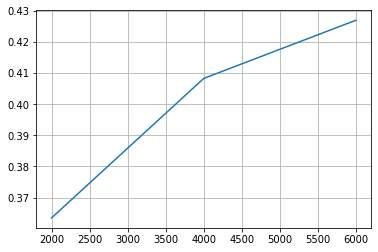

In [32]:
from IPython.display import clear_output, display

device = torch.device('cuda')
model = Net().to(device)
data = batch.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
epochs = 6000
model.train()
acc_history = []
epoch_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    # print(out.shape)
    # print(out[0])
    # loss = F.nll_loss(out, data.y)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()
    if (epoch + 1) % 2000 == 0:
        _, pred = model(data).max(dim=1)
        correct = float (pred.eq(data.y).sum().item())
        acc = correct / float(data.y.shape[0])
        acc_history.append(acc)
        epoch_history.append(epoch)
        clear_output(wait=True)
        
        print('[{}/{}] Loss: {:.4f} / Acc: {:.4f}'.format(epoch, epochs, total_loss, acc))
        fig, ax = plt.subplots()
        ax.plot(epoch_history, acc_history)
        ax.grid()       
        plt.show()
    

In [33]:
torch.save(model, '../model/taekwondo_activity_segmentation_temp.pth')

/home/danilo/anaconda3/envs/pygeo/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
conv1.weight 	 torch.Size([3, 8])
conv1.bias 	 torch.Size([8])
conv2.weight 	 torch.Size([8, 16])
conv2.bias 	 torch.Size([16])
conv3.weight 	 torch.Size([16, 32])
conv3.bias 	 torch.Size([32])
conv4.weight 	 torch.Size([32, 7])
conv4.bias 	 torch.Size([7])


# Testando um caso

In [136]:
test_athlete = 1
test_data = data.to_data_list()[test_athlete]
_, pred = model(test_data).max(dim=1)
pred_cpu = pred.cpu().numpy()
label_cpu = test_data.y.cpu().numpy()
result = pred_cpu==label_cpu
print('Accuracy: {}'.format(result.sum()/pred_cpu.shape[0]))

Accuracy: 0.5395


/home/danilo/anaconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [137]:
label_colors = {
    0: matplotlib.colors.to_rgb('#c62bc6'),
    1: matplotlib.colors.to_rgb('#49bcad'),
    2: matplotlib.colors.to_rgb('#e1ff00'),
    3: matplotlib.colors.to_rgb('#00bbff'),
    4: matplotlib.colors.to_rgb('#ffd800'),
    5: matplotlib.colors.to_rgb('#00ff11'),
    6: matplotlib.colors.to_rgb('#001dff'),
    7: matplotlib.colors.to_rgb('#fff600'),
    8: matplotlib.colors.to_rgb('#d65968'),
}

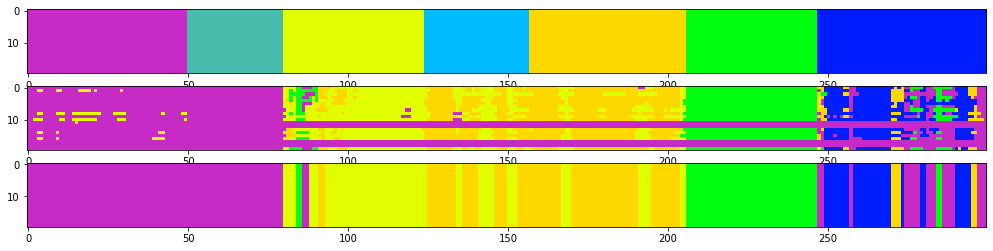

In [166]:
from scipy import stats

colored_labels = np.array([ label_colors[i] for i in label_cpu.flatten()])
colored_labels = colored_labels.reshape((-1,20, 3))

colored_preds = np.array([ label_colors[i] for i in pred_cpu.flatten()])
colored_preds = colored_preds.reshape((-1,20, 3))

frame_wise_mode = stats.mode(pred_cpu.reshape((-1,20)), axis=1)
frame_pred = frame_wise_mode[0]
colored_frame_pred = np.array([ [label_colors[i] for j in range(20)]  for i in frame_pred.flatten()])


fig=plt.figure(figsize=(20, 4))
fig.add_subplot(3, 1, 1)
plt.imshow(np.transpose(colored_labels, (1,0,2)))
fig.add_subplot(3, 1, 2)
plt.imshow(np.transpose(colored_preds, (1,0,2)))
fig.add_subplot(3, 1, 3)
plt.imshow(np.transpose(colored_frame_pred, (1,0,2)))

plt.show()